# Data Collection

In [ ]:
!python3 data_collection/data_collection.py

# Kotlin dataset analysis

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import files
import torch
from transformers import AutoTokenizer, PhiForCausalLM
from datasets import Dataset
from tqdm import tqdm


dataset_path = "/content/kotlin_dataset.csv"
df = pd.read_csv(dataset_path)

In [13]:
all_samples = len(df)
samples_with_docstring = df['docstring'].notna().sum()
print(
    f"{samples_with_docstring} out of {all_samples} with docstring | "
    f"{'{:0.2f}'.format(samples_with_docstring / all_samples * 100)}%"
)

7017 out of 79567 with docstring | 8.82%


In [14]:
all_samples = len(df)
samples_with_body = df['body'].notna().sum()
print(
    f"{samples_with_body} out of {all_samples} with body | "
    f"{'{:0.2f}'.format(samples_with_body / all_samples * 100)}%"
)

70248 out of 79567 with body | 88.29%


In [15]:
df = df.dropna(subset=['docstring']).dropna(subset=['body'])
df.sample(3)

,signature,body,docstring,id
14071,public fun getAndSet(newValue: NativePtr): Nat...,{\n while (true) {\n val old = value...,/**\n\n * Atomically sets the value to the...,f3718:m379
15379,@Test fun acosD(),{\n val r = cos(acos(ADJ / HYP))\n val l...,/**\n\n * Tests kotlin.math.acos(Double)\n...,f3868:m221
13733,@kotlin.internal.IntrinsicConstEvaluation publ...,this + other.toFloat(),/** Adds the other value to this value. */,f3686:m3923


In [16]:
print("Dataset information:")
print(df.info())

print("\nSummary statistics for numerical columns:")
print(df.describe())

Dataset information:
<class 'pandas.core.frame.DataFrame'>
Index: 5369 entries, 195 to 70407
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   signature  5369 non-null   object
 1   body       5369 non-null   object
 2   docstring  5369 non-null   object
 3   id         5369 non-null   object
dtypes: object(4)
memory usage: 209.7+ KB
None

Summary statistics for numerical columns:
          signature  body                                          docstring  \
count          5369  5369                                               5369   
unique         3971  3287                                               2855   
top     fun usage()   { }  /**\n\n     * Compares this value with the spe...   
freq             35    82                                                 90   

               id  
count        5369  
unique       5369  
top     f100:m939  
freq            1  


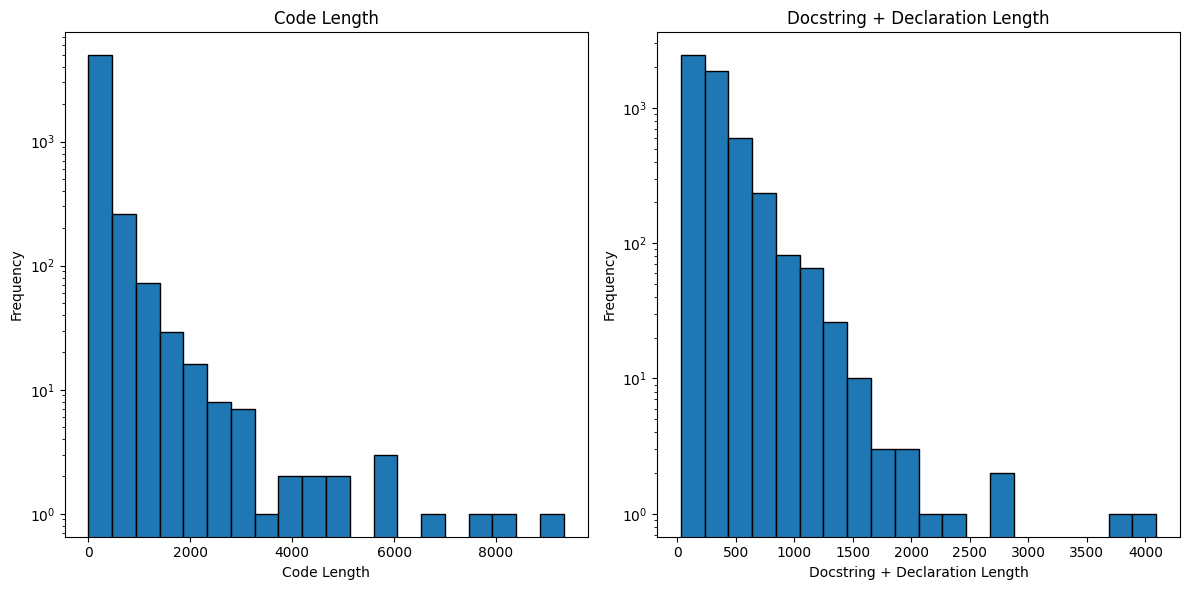

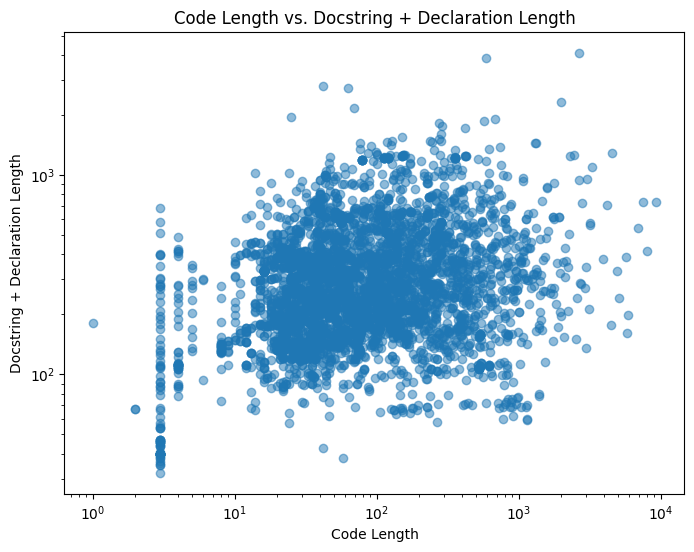

In [17]:
df['code_length'] = df['body'].astype(str).apply(len)
df['docstring_declaration_length'] = df['docstring'].apply(len) + df['signature'].apply(len)


fig1, axes1 = plt.subplots(1, 2, figsize=(12, 6))

axes1[0].hist(df['code_length'], bins=20, edgecolor='black')
axes1[0].set_title('Code Length')
axes1[0].set_xlabel('Code Length')
axes1[0].set_ylabel('Frequency')
axes1[0].set_yscale('log')

axes1[1].hist(df['docstring_declaration_length'], bins=20, edgecolor='black')
axes1[1].set_title('Docstring + Declaration Length')
axes1[1].set_xlabel('Docstring + Declaration Length')
axes1[1].set_ylabel('Frequency')
axes1[1].set_yscale('log')

plt.tight_layout()
plt.show()


fig2, ax2 = plt.subplots(figsize=(8, 6))

ax2.scatter(df['code_length'], df['docstring_declaration_length'], alpha=0.5)
ax2.set_title('Code Length vs. Docstring + Declaration Length')
ax2.set_xlabel('Code Length')
ax2.set_ylabel('Docstring + Declaration Length')
ax2.set_xscale('log')
ax2.set_yscale('log')

plt.show()

In [18]:
df = pd.read_csv("/content/kotlin_dataset.csv", sep=',')
df = df.dropna(subset=['docstring']).dropna(subset=['body'])

df['code_length'] = df['body'].astype(str).apply(len)
num_rows_to_keep = int(len(df) * 0.8)
dataset = df.nlargest(num_rows_to_keep, 'code_length')
dataset = dataset.drop(columns=['code_length'])

train_data, test_data = train_test_split(dataset, test_size=0.03, random_state=42)
test_data = test_data[:100]
print(f"train: {len(train_data)}\ntest: {len(test_data)}")
train_data.to_csv("/content/train_kotlin.csv")
test_data.to_csv("/content/test_kotlin.csv")
files.download("/content/train_kotlin.csv")
files.download("/content/test_kotlin.csv")

train: 4166
test: 100


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
model = PhiForCausalLM.from_pretrained("microsoft/phi-1_5")
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-1_5")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/736 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

100%|██████████| 100/100 [00:00<00:00, 234.75it/s]


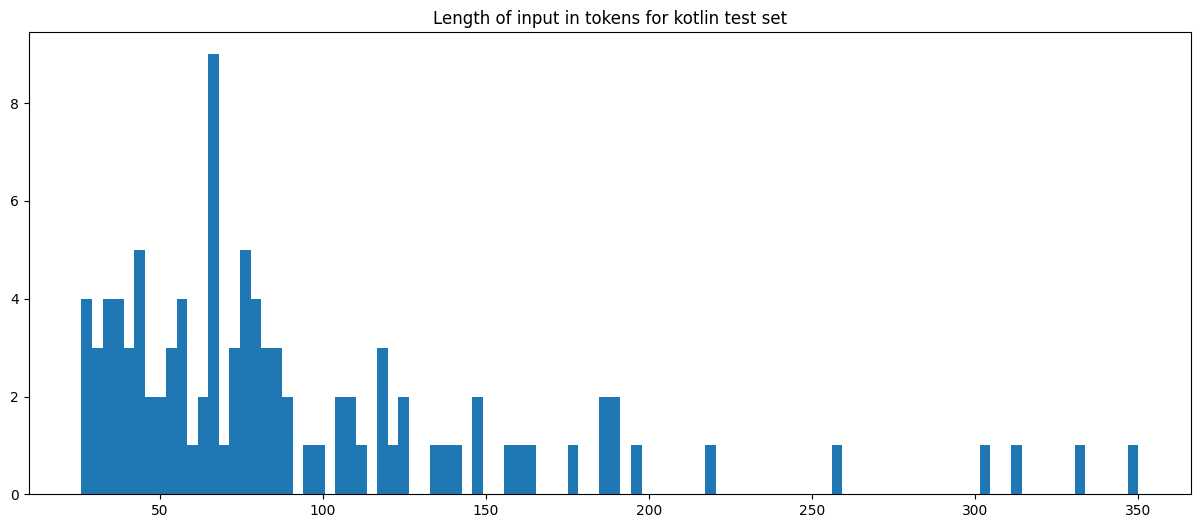

In [34]:
test_dataset = Dataset.from_pandas(test_data[:100])
data_to_tokens = []

for example in tqdm(test_dataset):
    inputs = tokenizer(example["signature"] + example["docstring"], return_tensors="pt", return_attention_mask=False)
    data_to_tokens.append(inputs)

lens = [len(t['input_ids'][0]) for t in data_to_tokens]
plt.figure(figsize=(15, 6))
plt.hist(lens, bins = 100)
plt.title('Length of input in tokens for kotlin test set')
plt.show()

100%|██████████| 100/100 [00:00<00:00, 269.50it/s]


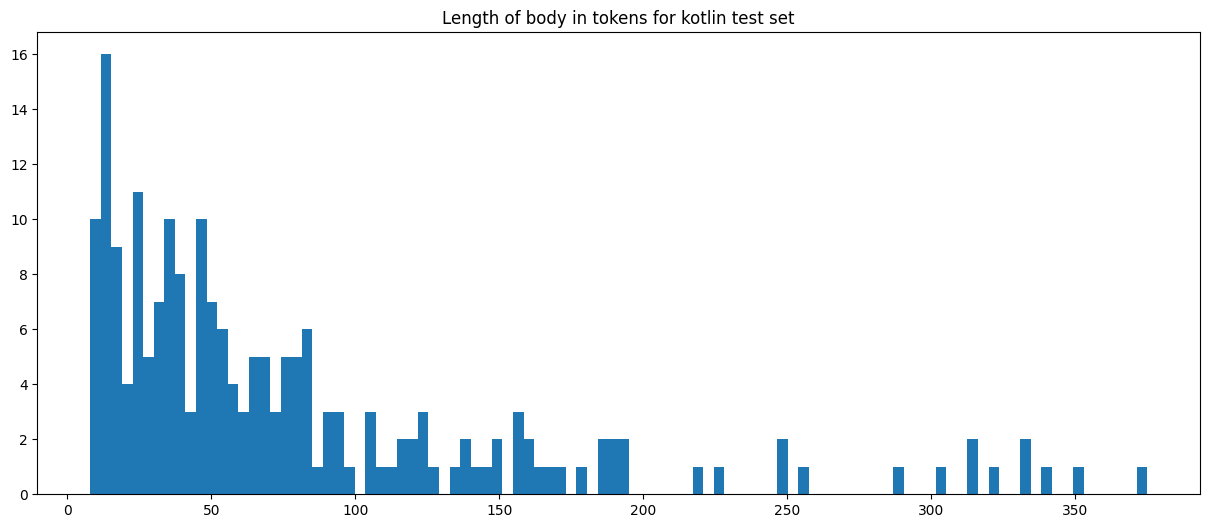

In [35]:
for example in tqdm(test_dataset):
    inputs = tokenizer(example["body"], return_tensors="pt", return_attention_mask=False)
    data_to_tokens.append(inputs)

lens = [len(t['input_ids'][0]) for t in data_to_tokens]
plt.figure(figsize=(15, 6))
plt.hist(lens, bins = 100)
plt.title('Length of body in tokens for kotlin test set')
plt.show()

# Python test set analysis

In [3]:
!git lfs clone https://huggingface.co/datasets/microsoft/codexglue_method_generation
!pip install fuzzywuzzy

          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'codexglue_method_generation'...
remote: Enumerating objects: 20, done.
remote: Total 20 (delta 0), reused 0 (delta 0), pack-reused 20 (from 1)
Unpacking objects: 100% (20/20), 2.31 KiB | 236.00 KiB/s, done.


100%|██████████| 100/100 [00:00<00:00, 325.81it/s]


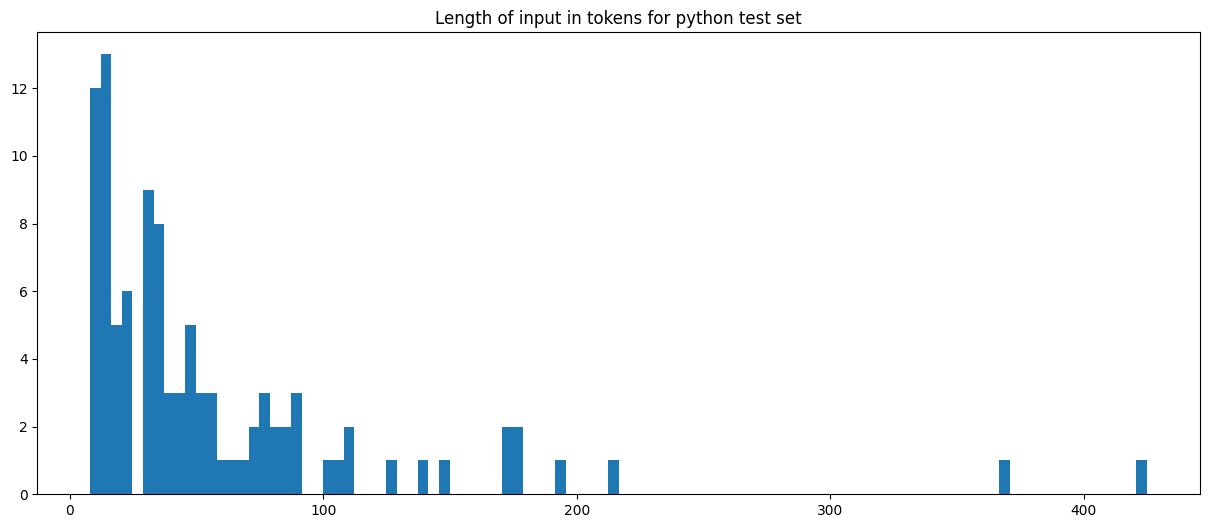

In [31]:
df_test = pd.read_json("/content/codexglue_method_generation/test.jsonl", lines=True)
test_dataset = Dataset.from_pandas(df_test[:100])
data_to_tokens = []

for example in tqdm(test_dataset):
    inputs = tokenizer(example["signature"] + example["docstring"], return_tensors="pt", return_attention_mask=False)
    data_to_tokens.append(inputs)

lens = [len(t['input_ids'][0]) for t in data_to_tokens]
plt.figure(figsize=(15, 6))
plt.hist(lens, bins = 100)
plt.title('Length of input in tokens for python test set')
plt.show()

100%|██████████| 100/100 [00:00<00:00, 543.98it/s]


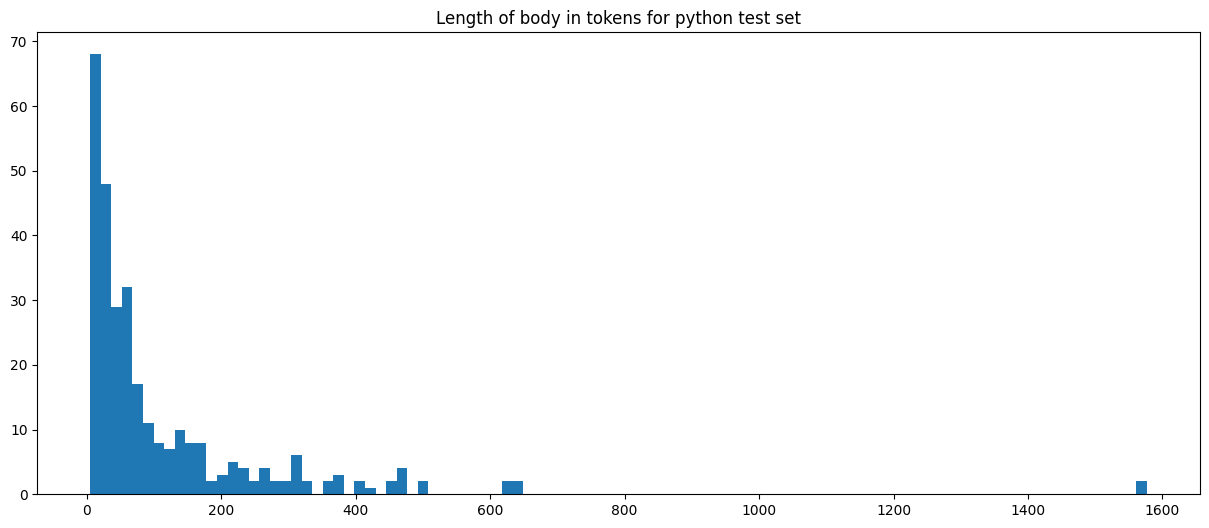

In [33]:
for example in tqdm(test_dataset):
    inputs = tokenizer(example["body"], return_tensors="pt", return_attention_mask=False)
    data_to_tokens.append(inputs)

lens = [len(t['input_ids'][0]) for t in data_to_tokens]
plt.figure(figsize=(15, 6))
plt.hist(lens, bins = 100)
plt.title('Length of body in tokens for python test set')
plt.show()